# Introducrtion to Machine Learning: Assignment #4
## Submission date: 15\07\2025, 23:59.
### Topics:
- AdaBoost
- PAC, VCdim
- Bias vs Variance
- K means clustering
- Decision Trees

Submitted by:

 **Student 1 Name+ID

 **Student 2 Name+ID

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## load smiling dataset

From now on, we will deal with the Smiling-face dataset, which determines if a person is smiling or not.

You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The algorithm expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((non_smile, smile))
dataset = dataset / 255

labels = [0] * len(non_smile) + [1] * len(smile)
labels = np.array(labels)

display smiling and non-smiling image.

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

## Question 1 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [21]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))
		# Implement here
		for cluster in range(self.n_clusters):
			m=labels==cluster
			centroids[cluster] = X[m].mean(axis=0)
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids
			# For each point, calculate distance to all k clustes.
			dist = self.compute_distance(X,old_centroids)
			self.labels = self.find_closest_cluster(dist)	# Assign the labels with closest distance' cluster.
			self.centroids = self.reassign_centroids(X,self.labels) # Update the centroids
			if np.all(old_centroids == self.centroids):
				break
		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Lets test this on toy example

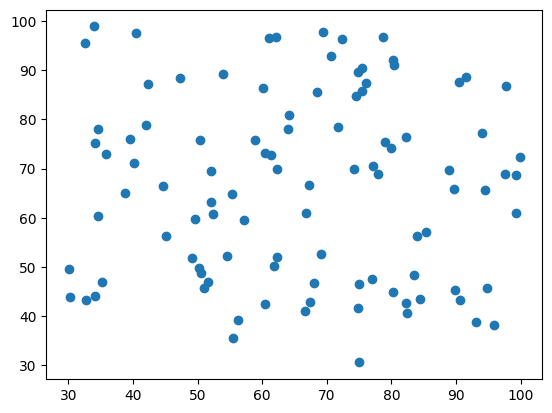

In [22]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

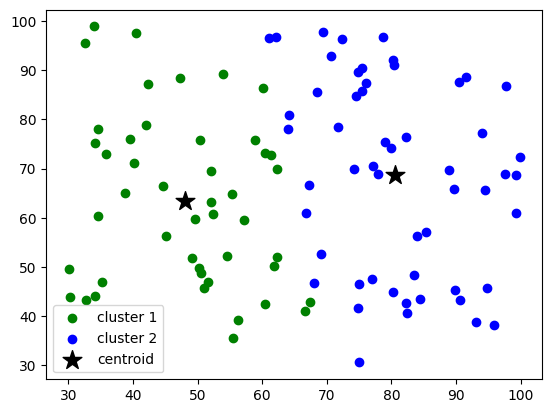

In [23]:
cluster = Kmeans(n_clusters=2)
cluster.fit(data)

# This code plots the clustered data with centroids
labels = cluster.labels
centroids = cluster.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Now, apply clustering from the smiling faces dataset.

Use the Elbow Method to choose another number of centroids between 1-5. <br/>
<font color='red'>*Seems like 4*</font>

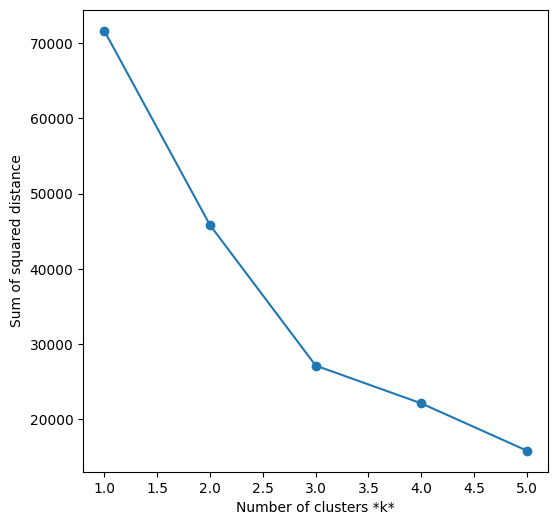

In [28]:
sse = []
list_k = list(range(1, 6))

for k in list_k:
  cluster= Kmeans(n_clusters=k)
  cluster.fit(data)
  sse.append(cluster.error)
  #sse.append(error_of_current_clustering)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

In [ ]:
# Implement here
clstr = Kmeans(n_clusters = 4)
clstr.fit(data)

## Question 2 - Adaboost

In this exercise you will (pratially) implement AdaBoost and see how boosting can be applied to real-world problems, in detection of smiling or non-smiling face. <br/>



Until now, we saw AdaBoost only on 2d data and chose an axis aligned threshold, in parallel x or y axis, since we had 2 features.

In d dimensions we will still choose an axis aligned threshold (hyperplane) but along the feature axis (1,…,d) that gives the best weak learner.

In [ ]:
#@title Find the best classifier. You can see this as blackbox
# Those who want to understand more - talk to me :)

def WL_by_sign_b(X_train, y_train, D, sign_b):
    F_min = sum(D[y_train == sign_b])       #the max error weight is all those who match sign_b
    tetha_min = X_train[0,0] - 1
    J_min = 0
    m, d = X_train.shape

    for j in range(d):    #choose index j for h, d = 5000
        values_wrt_j = np.column_stack((X_train[:,j],y_train, D))
        values_wrt_j = values_wrt_j[np.argsort(values_wrt_j[:, 0])]
        last = np.array([values_wrt_j[-1,0]+1, 0, 0])
        values_wrt_j = np.vstack((values_wrt_j, last))     # add x_m+1,j = x_m,y  +1
        F = sum(D[y_train == sign_b])

        #choose tetha for h
        Fs = F - np.cumsum(sign_b * values_wrt_j[:m,1] * values_wrt_j[:m,2])
        min_idx = np.argmin(Fs)
        if Fs[min_idx] < F_min:
          F_min = Fs[min_idx]
          tetha_min = 0.5 * sum(values_wrt_j[min_idx:min_idx+2,0])
          J_min = j

    return (J_min,tetha_min, F_min)

You are given the function ```get_hypothesis(X_train, y_train, D)``` which uses the train data, labels and the distribution over the samples (weights) and returns the best classifier.

Make sure to understand this tuple and the meaning of its variables.

In [ ]:
def get_hypothesis(X_train, y_train, D):
    """
    return best weak learner h
    h = (h_pred, h_index, h_theta)
    - h_index is the feature in which the axis-aligned hyperplane is
    - h_theta is the treshold
    - h_pred is the label assigned if the feature h_index of the sample x <= h_theta
    """

    Min_feature_idx1, tetha_min1, F_min1 = WL_by_sign_b(X_train, y_train, D, 1)
    Min_feature_idx2, tetha_min2, F_min2 = WL_by_sign_b(X_train, y_train, D, -1)
    if F_min1 < F_min2:
        return (1, Min_feature_idx1, tetha_min1)
    else:
        return (-1, Min_feature_idx2, tetha_min2)

# returns +1 | -1 only. For 0 returns +1. Use this
def sign(expr):
  return np.sign(np.sign(expr) + 0.5)

Implement the following:<br/>
- ```predict_wrt_h(X, h)```: should return the predictions of $X\in\mathbb{R}^{n\times d}$, according to the classifier.
- ```zo_loss_wrt_h(X, y, h)```: returns the 0-1 loss (delta) for $X\in\mathbb{R}^{n\times d}$, if predictions differ from the real labels.
- ```get_weighted_error(X_train, y_train, D, h)```: returns the $ε_t$, the weights sum of the misclassified samples.


In [ ]:
def predict_wrt_h(X, h):
    """
    h = (h_pred, h_index, h_theta)
    - h_index is the feature in which the axis-aligned hyperplane is
    - h_theta is the treshold
    - h_pred is the label assigned if the feature h_index of the sample x <= h_theta

    This function should return h_pred if the h_index feature of X is less (or equal) than the treshold h_theta
    otherwise, returns the opposite of h_pred
    """
    # Implement here

def zo_loss_wrt_h(X, y, h):
    """
    return delta(h(x),y), which is array of 0-1
    """
    # Implement here

def get_weighted_error(X_train, y_train, D, h):
    """
    return epsilon_t
    e.g sum of D[i]*delta(h(xi),yi)
    """
    # Implement here

Implement ```run_adaboost(X_train, y_train, T)```: runs the AdaBoost algorithm for T steps and returns a list of classifiers (hypotheses), and list of alpha values ($α_t$ for each iteration T). <br/>
Hint: the only 'for' loop needed is over T. The rest can be done efficiently using numpy and previous implemented functions.

In [ ]:
def run_adaboost(X_train, y_train, T):
    """
    Returns:
        hypotheses :
            A list of T tuples describing the hypotheses chosen by the algorithm.
            Each tuple has 3 elements (h_pred, h_index, h_theta)
            h = (h_pred, h_index, h_theta)
            - h_index is the feature in which the axis-aligned hyperplane is
            - h_theta is the treshold
            - h_pred is the label assigned if the feature h_index of the sample x <= h_theta
        alpha_vals :
            A list of T float values, which are the alpha values obtained in every
            iteration of the algorithm.
    """
    alpha_vals = []
    hypotheses = []
    D = np.ones(len(X_train)) / len(X_train)

    #Implement here

    return hypotheses, alpha_vals

Implement ```calc_error(data, labels, hypotheses, alpha_vals)```:

For each iteration $t=1,...,T$, calculate the error rate (from $1,...,t$). <br/>

In [ ]:
def calc_error(data, labels, hypotheses, alpha_vals):
    """
    calc empirical error
    classfication is sign of sum of a_t*h_t(x)

    Return list of mean errors using 1,...,T hypotheses
    """
    # Implement here

    return error_all_t

Prepear the adaboost run.
- 80 iterations.
- Use the labels 0/1 into -1/1.

This is due to the fact that classification based on sign which is -1,+1.

In [ ]:
T = 80

y_train_ada = y_train.copy()
y_test_ada = y_test.copy()

y_train_ada[y_train == 0] = -1
y_test_ada[y_test == 0] = -1

Run the AdaBoost algorithm on the train and test <b>after</b> performing PCA.

In [ ]:
hypotheses, alpha_vals = run_adaboost(x_train_new, y_train_ada, T)

Plot the train and test erros as function of T

In [ ]:
train_error_t = calc_error(x_train_new, y_train_ada, hypotheses, alpha_vals)
test_error_t = calc_error(x_test_new, y_test_ada, hypotheses, alpha_vals)
X = np.arange(1,T+1)
plt.plot(X, train_error_t ,'b+', label = 'error of train set')
plt.plot(X, test_error_t ,'ro', label = 'error of test set')
plt.xlabel('t')
plt.legend()
plt.show()

Get the train and test accuracy

In [ ]:
print(f'final train accuracy {1-train_error_t[-1]}')
print(f'final test accuracy {1-test_error_t[-1]}')

Run the AdaBoost algorithm on the train and test <b>before</b> performing PCA. <br/>

Note: an efficient implementation should take up to 4 minutes of running.

In [ ]:
hypotheses, alpha_vals = run_adaboost(x_train_flatten, y_train_ada, T)
train_error_t = calc_error(x_train_flatten, y_train_ada, hypotheses, alpha_vals)
test_error_t = calc_error(x_test_flatten, y_test_ada, hypotheses, alpha_vals)
X = np.arange(1,T+1)
plt.plot(X, train_error_t ,'b+', label = 'error of train set')
plt.plot(X, test_error_t ,'ro', label = 'error of test set')
plt.xlabel('t')
plt.legend()
plt.show()

In [ ]:
print(f'final train accuracy {1-train_error_t[-1]}')
print(f'final test accuracy {1-test_error_t[-1]}')

Answer the following questions:
- Which dataset would you prefer to run on AdaBoost - before or after PCA?
- What are your conclusions on using AdaBoost in general?

<font color='red'>Write here your answers and explain them</font>

## Question 3 - Decision trees

You are requested by the Faculty of Biology to construct a classifier for predicting the quality of different fruits by several features.
<br/> For this, you will use decision trees!


The dataset consists of 7 features which were obtained from the biologists that collected data and normalized it to you.<br/>

Note that the features are continuous! Therefore, use only one threshold and split according to it.

In [ ]:
# Import libraries

import numpy as np
import pandas as pd

In [ ]:
# Load the data, print the first rows

data = pd.read_csv('https://srworkspace.com/sharon/ml/datasets/hw3/banana_quality.csv')
data.head(3)

Complete this missing implementation of the following functions:
- ```calculate_entropy(self, data)``` – given data, compute the entropy, where the distribution is over its labels (target class).
- ```calculate_information_gain(self, data, feature)``` – given data and specific feature, compute the information gain given by selecting that feature.

Algorithm: The data is continuous, so create 15 thresholds between the min and max values of that feature. For each threshold, split to left tree and right tree and calculate the gain. Choose the threshold which gives the highest gain, along with the gain itself (to later compare between features) <br/>

Tip: To split the tree (represented by data df), use filter_data.
For example, when calculating the gain of 'skew' with threshold 0.5, you can create the left tree by use ```filter_data(data, 'skew', '0.5', left=True)``` to obtain only those samples.

In [ ]:
# Define the ID3 decision tree class
class DecisionTree:
	def __init__(self):
		self.tree = {}

	def calculate_entropy(self, data):
		labels = data.iloc[:, -1]
		# Implement here

	def calculate_information_gain(self, data, feature):
		total_entropy = self.calculate_entropy(data)
		information_gain = total_entropy

		values = # generate 15 thresholds
		best_treshold = None
		best_gain = 0
		for value in values:
			# Implement here

		return best_gain, best_treshold

	def filter_data(self, data, feature, value, left=True):
		if left:
			return data[data[feature] <= value].drop(feature, axis=1)
		else:
			return data[data[feature] > value].drop(feature, axis=1)

	def create_tree(self, data, depth=0):
		# Recursive function to create the decision tree
		labels = data.iloc[:, -1]

		# Base case: if all labels are the same, return the label
		if len(np.unique(labels)) == 1:
			return list(labels)[0]

		features = data.columns.tolist()[:-1]
		# Base case: if there are no features left to split on, return the majority label
		if len(features) == 0:
			unique_labels, label_counts = np.unique(labels, return_counts=True)
			majority_label = unique_labels[label_counts.argmax()]
			return majority_label

		selected_feature = None
		best_gain = 0
		best_treshold = None

		for feature in features:
			gain, treshold = self.calculate_information_gain(data, feature)
			if gain >= best_gain:
				selected_feature = feature
				best_treshold = treshold
				best_gain = gain

		# Create the tree node
		tree_node = {}
		tree_node[(selected_feature, f"<={best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=True), depth+1)
		tree_node[(selected_feature, f">{best_treshold}")] = self.create_tree(self.filter_data(data, selected_feature, best_treshold, left=False), depth+1)

		# check if can unite them.
		if not isinstance(tree_node[(selected_feature, f"<={best_treshold}")], dict) and \
				not isinstance(tree_node[(selected_feature, f">{best_treshold}")], dict):
			if tree_node[(selected_feature, f"<={best_treshold}")] == tree_node[(selected_feature, f">{best_treshold}")]:
				return tree_node[(selected_feature, f"<={best_treshold}")]

		return tree_node

	def fit(self, data):
		self.tree = self.create_tree(data)

	def predict(self, X):
		X = [row[1] for row in X.iterrows()]

		# Predict the labels for new data points
		predictions = []

		for row in X:
			current_node = self.tree
			while isinstance(current_node, dict):
				split_condition = next(iter(current_node))
				feature, value = split_condition
				treshold = float(value[2:])
				if row[feature] <= treshold:
					current_node = current_node[feature, f"<={treshold}"]
				else:
					current_node = current_node[feature, f">{treshold}"]
			predictions.append(current_node)

		return predictions

	def _plot(self, tree, indent):
		depth = 1
		for key, value in tree.items():
			if isinstance(value, dict):
				print(" " * indent + str(key) + ":")
				depth = max(depth, 1 + self._plot(value, indent + 2))
			else:
				print(" " * indent + str(key) + ": " + str(value))
		return depth

	def plot(self):
		depth = self._plot(self.tree, 0)
		print(f'depth is {depth}')


You are ready - define DecisionTree, fit it on the entire data and plot the tree. <br/>
The depth of the tree should be 7

In [ ]:
# Implement here

The decision tree is pretty large (depth is 7). To solve this, lets modify our DecisionTree: <br/>
```
def __init__(self, max_depth=np.inf):
        self.tree = {}
        self.max_depth = max_depth
```

Modify the rest of the code to stop growing after max_depth. <br/>
Hint: When reached to max_depth, should we continue splitting? Which category will be best to be selected?


Compare max_depth=5 to max_depth=7. Based on the results, which depth is better for our problem in terms of ML? <br/>
<font color='red'>Write your answer here and explain it</font>

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

for depth in [5, 7]:
  print(f"------------ max_depth={depth} "------------")
  # Implement here
  print(f'Training accuracy is {acc}')

  # Implement here
  print(f'Test accuracy is {acc}')
  print()

Now, use KFold (as seen in tutorials) for a cross validation search to the best depth for the tree.

In [ ]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for depth in tqdm(range(1,8)):
    # Implement here

plt.plot(range(1,6), accs)
plt.xticks(range(1,6))
plt.show()

Use that depth and print the test score. Is it better generalizer than the first one?

What do you conclude about the tuning proccess using validation? (answer to yourselves).

In [ ]:
# Implement here

## Question 4 - PAC, VCdim

Answer here or in the pdf, with full explanations.

Section 1:

To review, let the sample space be $X = [0, 1]$ and assume we study a binary classification problem, i.e. $Y = \{0, 1\}$. We will try to learn using an hypothesis class that consists of $k$ intervals.

More explicitly, let $I = \{[l1, u1], . . . , [lk, uk]\}$ be $k$ disjoint
intervals, such that $0 ≤ l_1 ≤ u_1 ≤ l_2 ≤ u_2 ≤ . . . ≤ u_k ≤ 1$. For each such $k$ disjoint intervals, define the corresponding hypothesis as
$$
h_I(x)=\begin{cases}1 & x\in[l_1, u_1] \cup\ldots\cup [l_k, u_k] \\ 0 & \text{else}\end{cases}
$$

Finally, define $\mathcal{H}$ as the hypothesis class that consists of all hypotheses that correspond to $k$ disjoint intervals:
$$
\mathcal{H}_k=\{h_I|I=\{[l_1, u_1], . . . , [l_k, u_k]\}, 0 ≤ l_1 ≤ u_1 ≤ l_2 ≤ u_2 ≤ . . . ≤ u_k ≤ 1\}
$$

Moreover, the data will be generated from the probability:
$$
\mathbb{P}(Y=1|x)=\begin{cases}0.8 & x\in[0,0.2]\cup[0.4,0.6]\cup[0.8,1]\\0.1 & x\in(0.2,0.4)\cup(0.6,0.8)\end{cases}
$$

Answer the following questions:
1. Is this PAC or Agnostic PAC model? Explain.
2. How the optimal classifier $h\in\mathcal{H}$ will look like?
3. What is the real-world error of that $h$?


Section 2:

A circle (r,c) is defined by its center c and its radius r. Look at the following classifiers family:
$$
H=\{h_{(r,c)}:  r\in\mathbb{R},c∈\mathbb{R}^2 \}$$

where $h_{(r,c)}(x)=1$ iff $x$ inside the circle $(r,c)$

Find the VCdim of this class with full proof.

## Bonus: 15 pts
Build a model which gets at least 90% accuracy on the test of the smiling faces data. Please Submit only your final model with results.

**Do not** try to use techniques we didn't learn about in the course.

<font color='red'>Explain your choices and what you have tried</font>